In [30]:
import numpy as np
import matplotlib.pyplot as plt
import shapefile
import matplotlib.colors as colors
#from matplotlib.patches import Polygon
import pandas as pd
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch 
import cmocean
import matplotlib.cm as cmx
from matplotlib.colorbar import ColorbarBase
from matplotlib.collections import PatchCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [235]:
# source of the school district shapefiles is from the US Census Bureau but....they have a screw up in their system. Though the UNSD
# file is supposed to be all Unified School Districts (thank god they're mostly by county or incorporated city unlike say Arizona), one
# unifed school district, Lexington City Schools which has elementary, middle & high school has it's own special shapefile as a
# an elementary school district for the Census Bureau. So I just merged the two danged files with pyshp/shapefile and made the shapefile
# relevant files with a suffix of _combined
# shapefiles are the 2017 versions sourced at https://www.census.gov/geo/maps-data/data/cbf/cbf_sd.html


sf = shapefile.Reader('/mnt/c/Users/erinl/Desktop/virginia_census_regions/cb_2017_51_unsd_500k/cb_2017_51_unsd_500k_combined')

fields = sf.fields
shapes = sf.shapes
records = sf.records()


def find_column(column_name):
    for fieldno in range(len(sf.fields)):
        if (sf.fields[fieldno][0] == column_name):
            #print("Column number: {0} is {1}.f".format(fieldno, column_name))
            return fieldno-1
 

FULLNAME = find_column('NAME')

school_districts = []



# the common info in all the files is going to be a flavor of school district name. The Census Bureau has a love of labeling everything
# <placename> Public Schools, but then the Commonwealth of Virginia just uses <placename>

for shapeno in range(len(records)):
    schools = records[shapeno][FULLNAME]
    district = schools.rstrip(' Public Schools')
    school_districts.append(district)
        

['Louisa County', 'Isle of Wight County', 'Greensville County', 'Colonial Beach Town', 'Lunenburg County', 'Lee County', 'Madison County', 'Rappahannock County', 'Amherst County', 'Quantico Marine Corps Center School District', 'Charlotte County', 'Bath County', 'Tazewell County', 'Floyd County', 'Page County', 'Buckingham County', 'Lancaster County', 'King and Queen County', 'Prince George County', 'Prince William County', 'Patrick County', 'Dahlgren Department of Defense School District', 'King George County', 'Bedford County', 'Surry County', 'Nelson County', 'James City County', 'Montgomery County', 'Albemarle County', 'Richmond County', 'Prince Edward County', 'Pittsylvania County', 'Alleghany County', 'Russell County', 'Charles City County', 'Mecklenburg County', 'Henrico County', 'Spotsylvania County', 'Middlesex County', 'Northumberland County', 'Stafford County', 'Essex County', 'Washington County', 'New Kent County', 'Orange County', 'Buchanan County', 'Highland County', 'Roc

In [236]:
# Now to the Virginia SOLs. Not that the students are shit out of luck, it's Standards of Learning.
# Data the state has is on pass rates for the last 3 years. In one case on the state level, in the other case on the district level
# Data grabbed from http://www.doe.virginia.gov/statistics_reports/school_report_card/index.shtml#solresults
# Note: I did have to edit the district level file, the Commonwealth is not consistent on using a < as the "not enough students to report"
# and also in some districts they dropped whole classifications. So editting with the assistance of colorful language and a beverage was done

sol_state_data = pd.read_csv('/mnt/c/Users/erinl/Desktop/va_school_data/2017-2018-state-subject-area.csv')
print (sol_state_data.loc[sol_state_data['Subgroup'] == 'All Students'])

print ('Possible student classes', pd.Series(sol_district_data['Subgroup']).unique())


sol_district_data = pd.read_csv('/mnt/c/Users/erinl/Desktop/va_school_data/2017-2018-division-subject-area.csv')



    Level                      Subject      Subgroup  2015-2016 Pass Rate  \
0   State             English: Reading  All Students                 80.0   
16  State             English: Writing  All Students                 77.0   
32  State  History and Social Sciences  All Students                 86.0   
48  State                  Mathematics  All Students                 80.0   
64  State                      Science  All Students                 83.0   

    2016-2017 Pass Rate  2017-2018 Pass Rate  
0                  80.0                   79  
16                 79.0                   78  
32                 86.0                   84  
48                 79.0                   77  
64                 82.0                   81  
Possible student classes ['All Students' 'Asian' 'Black' 'Economically Disadvantaged'
 'English Learners' 'Female' 'Hispanic' 'Male'
 'Students with Disabilities' 'White' nan]


/home/erin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


No State SOL data for Quantico Marine Corps Center School District
No State SOL data for Dahlgren Department of Defense School District
Under performing districts ['Petersburg City']
Pass rate difference for under performing vs state -29.0


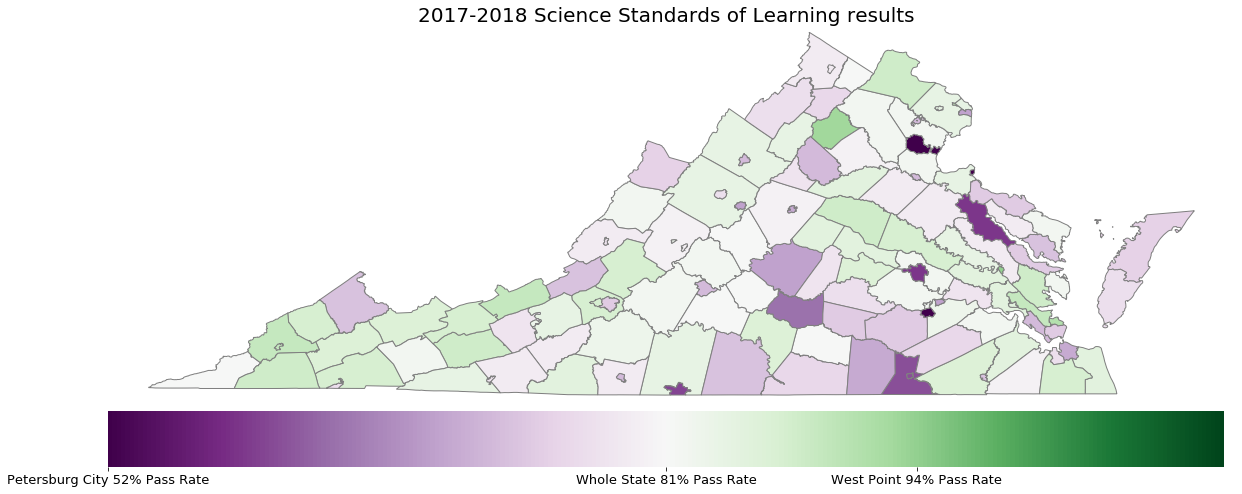

In [163]:
# time to pick with Subject and which testing year
# So up above we printed out all the state test options  and those are:
# English: Reading, English: Writing, Mathematics, Science, History and Social Sciences
# So, have now written this so you can pick whichever student class you want which I printed up top too
topic = 'Science'
test_year = '2017-2018'
group = 'All Students'

state_test = sol_state_data.loc[(sol_state_data['Subgroup'] == group) & (sol_state_data['Subject'] == topic)]
state_value = np.float_(state_test[test_year+' Pass Rate'])

district_test = sol_district_data.loc[(sol_district_data['Subgroup'] == group) & (sol_district_data['Subject'] == topic)]
school_names = np.array(district_test['Div Name'])
district_value = np.array(district_test[test_year+' Pass Rate'])
district_value[district_value == '<'] = np.nan
district_value = np.float_(district_value)


# to not totally skew the statistics I do nan out the School for Deaf and Blind
deaf_and_blind = np.where(school_names == 'Virginia School for the Deaf and Blind-Staunton')
district_value[deaf_and_blind] = state_value

# okay so of course first test is seeing how the pass rates in individual counties differ from the state value and from district to district
differ_values = district_value - state_value


# set the plotting color interval. Since Colormaps run from 0 to 1 and the center of a diverging colormap is at a value of 0.5
# I use the max deviation from the state's passing rate and then construct a linear interval
# of course this means the extreme colors in the color map only show up in the underperforming side of things since
# the state passing rates are in practice > 70%, but again, good enough for hacky farting around
interval = (1/(np.nanmax(np.abs(differ_values))))/2
icolor = 0.5 * np.ones(len(differ_values))
icolor = icolor +differ_values*interval



# release the hounds! Oh wait...start the plotting
# I go through the plot and basically "draw" it, then add a patch for each district in the loop. I'm not sure if the loop is the most 
# efficient (Hi, girl who originally learned Fortran77 here), but it works

fig, ax1 = plt.subplots(figsize=(20,10))
ax1 = plt.axes() # add the axes
ax1.set_aspect('equal')


mypatches = []

i = 0

for shape in list(sf.iterShapes()):
    
    district = np.array(school_districts[i])
    
    # Okay so I discovered some other districts aren't named appropriately in the Census file, le argh 
    # Also Williamsburg City and James County and Emporia City and Greenville County have a cooperative
    # operating agreement in place, so their state scores get reported as the combined district
    
    if (district == 'Colonial Beach Town'):
        district = 'Colonial Beach'
    if (district == 'James City County'):
        district = 'Williamsburg-James City County'
    if (district == 'Williamsburg City'):
        district = 'Williamsburg-James City County'
    if (district == 'West Point Town'):
        district = 'West Point'
    if (district == 'Fairfax City'):
        district = 'Fairfax County'
    if (district == 'Emporia City'):
        district = 'Greensville County'
   
    array_match, = np.where(district == school_names)
     
    
    if (len(array_match) == 1):
        this_color= icolor[array_match][0]
    if (len(array_match) == 0):
        # Okay so there are two districts in the shapefile with no state testing data: the DoD schools
        # this is a bit of an unneeded relic, but I want to make sure I'm not neglecting any district in the shapefile
        this_color= 0
        print ('No State SOL data for', district)
    
    nparts = len(shape.parts) # total parts
    if nparts == 1:
        polygon = Polygon(shape.points)
        patch = PolygonPatch(polygon, facecolor=plt.cm.PRGn(this_color), zorder=2, ec='0.5')
        ax1.add_patch(patch)
        mypatches.append(patch)

    else: # loop over parts of each shape, plot separately 
        for ip in range(nparts): # loop over parts, plot separately
            i0=shape.parts[ip]
            if ip < nparts-1:
                i1 = shape.parts[ip+1]-1
            else:
                i1 = len(shape.points)

            polygon = Polygon(shape.points[i0:i1+1])
            patch = PolygonPatch(polygon, facecolor=plt.cm.PRGn(this_color), zorder=2, ec='0.5')
            ax1.add_patch(patch)
            mypatches.append(patch)

    i = i + 1
    
# okay I want to mark on a colorbar where the most over- and most under- performing school happen to be, esp relative
# to the state average and want to label which counties those happen to me

over_district = np.where(differ_values == np.nanmax(differ_values))
under_district, = np.where(differ_values == np.nanmin(differ_values))

over_district_tick = icolor[over_district][0]
under_district_tick = icolor[under_district][0]

over_district_label = school_names[over_district][0]+' '+str(int(district_value[over_district][0]))+'% Pass Rate'
under_district_label = school_names[under_district][0]+' '+str(int(district_value[under_district][0]))+'% Pass Rate'

p = PatchCollection(mypatches, cmap=plt.get_cmap('PRGn'), alpha=1.0)
p.set_array([0,0.5,1])
#plt.text(-84,35.0, 'Worse')

if (icolor[under_district][0] == 0):
    cbar = fig.colorbar(p,orientation='horizontal', ticks=[under_district_tick,0.5,over_district_tick], pad=0.02)
    cbar.set_ticklabels([under_district_label,'Whole State '+str(int(state_value))+'% Pass Rate',over_district_label])
    cbar.ax.tick_params(labelsize=13)
    cbar.outline.set_visible(False)
if ((differ_values[under_district][0] != 0) & (icolor[under_district][0] != 0)):
    cbar = fig.colorbar(p,orientation='horizontal', ticks=[0,under_district_tick,0.5,over_district_tick],pad=0.02)
    cbar.set_ticklabels(['Under', under_district_label,'Whole State '+str(int(state_value))+'% Pass Rate',over_district_label])
    cbar.ax.tick_params(labelsize=13)
    cbar.outline.set_visible(False)
if (differ_values[under_district][0] == 0):
    cbar = fig.colorbar(p,orientation='horizontal', ticks=[0,under_district_tick,over_district_tick], pad=0.02)
    cbar.set_ticklabels(['Under', under_district_label+' '+str(int(state_value))+'% Pass Rate',over_district_label])
    cbar.ax.tick_params(labelsize=13)
    cbar.outline.set_visible(False)

plt.xlim(-84,-75)
plt.ylim(36.5,39.5)
plt.axis('off')
plt.title(test_year+' '+topic+' Standards of Learning results', fontsize=20)
# Oh hey, we can porbably uncomment this next bit when wanting to save the figures, though dpi=180 may be overkill
#plt.savefig(topic+'_'+test_year+'.jpg', dpi=180)
#plt.close()
plt.show()

No State SOL data for Quantico Marine Corps Center School District
No State SOL data for Dahlgren Department of Defense School District


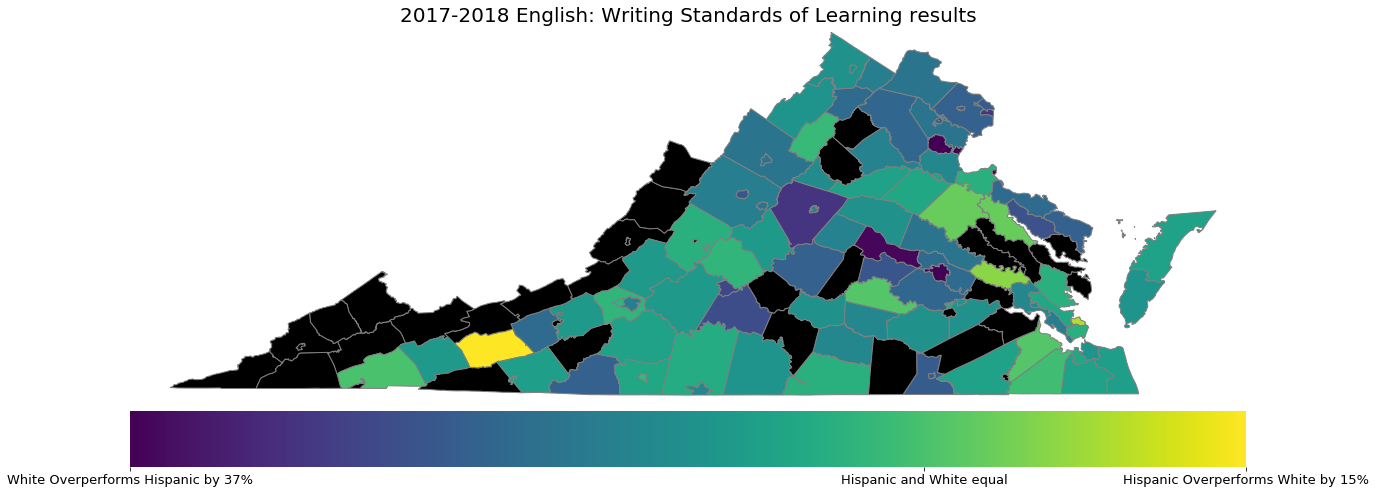

In [238]:
# Now to do the comparison within counties/districts version!


topic = 'English: Writing'
test_year = '2017-2018'
group1 = 'Hispanic'
group2 = 'White'



district_group1 = sol_district_data.loc[(sol_district_data['Subgroup'] == group1) & (sol_district_data['Subject'] == topic)]
district_group2  = sol_district_data.loc[(sol_district_data['Subgroup'] == group2) & (sol_district_data['Subject'] == topic)]



district_value1 = np.array(district_group1[test_year+' Pass Rate'])
district_value1[district_value1 == '<'] = np.nan
district_value1[district_value1 == '-'] = np.nan
district_value1 = np.float_(district_value1)

district_value2 = np.array(district_group2[test_year+' Pass Rate'])
district_value2[district_value2 == '<'] = np.nan
district_value2[district_value2 == '-'] = np.nan
district_value2 = np.float_(district_value2)

school_names = np.array(district_group1['Div Name'])

deaf_and_blind = np.where(school_names == 'Virginia School for the Deaf and Blind-Staunton')
district_value1[deaf_and_blind] = np.nan
district_value2[deaf_and_blind] = np.nan


differ_values = district_value1 - district_value2


# again, going for linear colorscales buttttt... sometimes the performance can be lopsided, like white kids
# always overperforming minorities, so gotta set up an option for both lopsided and variable across the board optiosn

if (np.nanmin(differ_values) < 0):
    performance = 'both'
    norm_icolor = (differ_values+abs(np.nanmin(differ_values)))/abs(np.nanmax(differ_values) - np.nanmin(differ_values))
    colors_midpoint = (0+abs(np.nanmin(differ_values)))/abs(np.nanmax(differ_values) - np.nanmin(differ_values))
  

if (np.nanmin(differ_values) >= 0):
    performance = 'group1'
    norm_icolor = (differ_values-np.nanmin(differ_values))/abs(np.nanmax(differ_values) - np.nanmin(differ_values))
    colors_midpoint = (0 +abs(np.nanmin(differ_values)))/abs(np.nanmax(differ_values) - np.nanmin(differ_values))



fig, ax1 = plt.subplots(figsize=(20,10))
ax1 = plt.axes() # add the axes
ax1.set_aspect('equal')


mypatches = []

i = 0

for shape in list(sf.iterShapes()):
    
    district = np.array(school_districts[i])
    
    if (district == 'Colonial Beach Town'):
        district = 'Colonial Beach'
    if (district == 'James City County'):
        district = 'Williamsburg-James City County'
    if (district == 'Williamsburg City'):
        district = 'Williamsburg-James City County'
    if (district == 'West Point Town'):
        district = 'West Point'
    if (district == 'Fairfax City'):
        district = 'Fairfax County'
    if (district == 'Emporia City'):
        district = 'Greensville County'
   
    array_match, = np.where(district == school_names)
    
   
    
    if (len(array_match) == 1):
        this_color= norm_icolor[array_match][0]
    if (len(array_match) == 0):
        this_color= 0
        print ('No State SOL data for', district)
    
    
    # okay so one note on colors....if there was no data for a class, the state used < to note that or I added - to the file
    # so up above I made those strings into nans. Meaning the differ value of the number of people passing is also then a nan
    # so, in the cases where nans are the thing and you can't compare groups, using the Grey color map and a color of 1 means
    # blacking out those counties in the map (sorry y'all)
    nparts = len(shape.parts) # total parts
    if nparts == 1:
        polygon = Polygon(shape.points)
        if (np.isfinite(this_color) == True):
            patch = PolygonPatch(polygon, facecolor=plt.cm.viridis(this_color), zorder=2, ec='0.5')
        if (np.isfinite(this_color) == False):
            patch = PolygonPatch(polygon, facecolor=plt.cm.Greys(1.), zorder=2, ec='0.5')
        ax1.add_patch(patch)
        mypatches.append(patch)

    else: # loop over parts of each shape, plot separately 
        for ip in range(nparts): # loop over parts, plot separately
            i0=shape.parts[ip]
            if ip < nparts-1:
                i1 = shape.parts[ip+1]-1
            else:
                i1 = len(shape.points)

            polygon = Polygon(shape.points[i0:i1+1])
            if (np.isfinite(this_color) == True):
                patch = PolygonPatch(polygon, facecolor=plt.cm.viridis(this_color), zorder=2, ec='0.5')
            if (np.isfinite(this_color) == False):
                patch = PolygonPatch(polygon, facecolor=plt.cm.Greys(1.), zorder=2, ec='0.5')            
            ax1.add_patch(patch)
            mypatches.append(patch)

    i = i + 1

over_district = np.where(differ_values == np.nanmax(differ_values))
under_district = np.where(differ_values == np.nanmin(differ_values))

over_district_tick = norm_icolor[over_district][0]
under_district_tick = norm_icolor[under_district][0]



p = PatchCollection(mypatches, cmap=plt.get_cmap('viridis'), alpha=1.0)
p.set_array([0,0.5,1])

if (performance == 'both'):
    over_district_label = group1+' Overperforms '+group2+' by '+str(int(np.nanmax(differ_values)))+'%'
    under_district_label = group2+' Overperforms '+group1+' by '+str(int(abs(np.nanmin(differ_values))))+'%'

    cbar = fig.colorbar(p,orientation='horizontal', ticks=[under_district_tick,colors_midpoint,over_district_tick], pad=0.02)
    cbar.set_ticklabels([under_district_label,group1+' and '+group2+' equal',over_district_label])
    cbar.ax.tick_params(labelsize=13)
    cbar.outline.set_visible(False)
    
if (performance == 'group1'):
    over_district_label = group1+' Overperforms '+group2+' by '+str(int(np.nanmax(differ_values)))+'%'
    under_district_label = group1+' Overperforms '+group2+' by '+str(int(np.nanmin(differ_values)))+'%'

    cbar = fig.colorbar(p,orientation='horizontal', ticks=[under_district_tick,colors_midpoint,over_district_tick], pad=0.02)
    cbar.set_ticklabels([under_district_label,group1+' and '+group2+' equal',over_district_label])
    cbar.ax.tick_params(labelsize=13)
    cbar.outline.set_visible(False)
    

plt.xlim(-84,-75)
plt.ylim(36.5,39.5)
plt.axis('off')

plt.title(test_year+' '+topic+' Standards of Learning results', fontsize=20)
#plt.savefig(topic+'_'+test_year+'.jpg', dpi=180)
#plt.close()
plt.show()


No State SOL data for Dahlgren Department of Defense School District
No State SOL data for Quantico Marine Corps Center School District


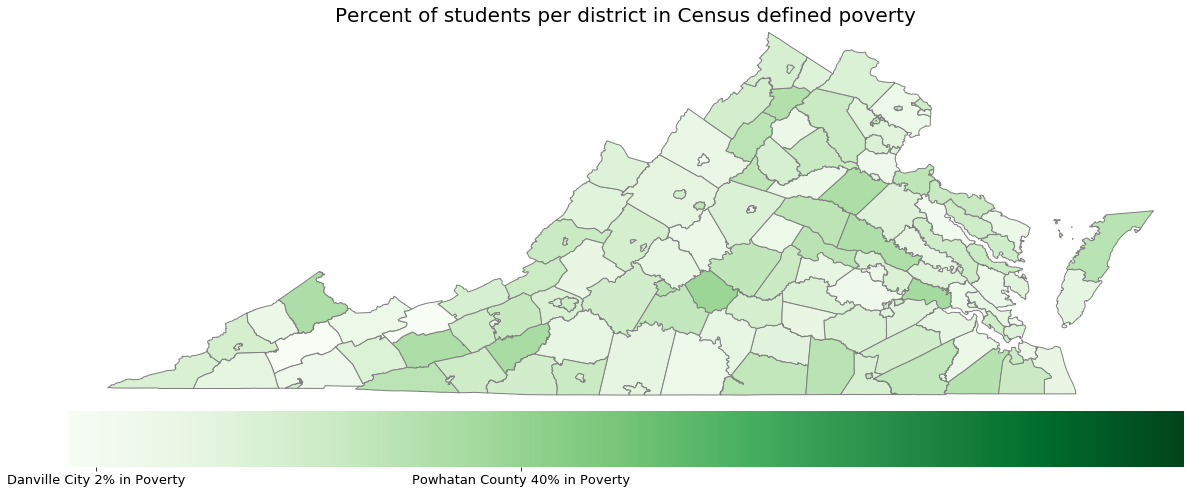

In [239]:
# okay, so via the Census from the SAIPE folks you can get file that gives total students per district and how many in poverty.
# it's kinda maybe fixed width, but I just loaded it into Excel and made it a csv.
# Original download file here: https://www.census.gov/data/datasets/2016/demo/saipe/2016-school-districts.html

poverty = pd.read_csv('/mnt/c/Users/erinl/Desktop/virginia_census_regions/sd16-va.csv', names=['state code', 'district id','district name', 
                                                                                              'total pop','student pop', 'students poverty',
                                                                                              'file','creation date'])
poverty_districts = []


for pp in range(len(poverty)):
    district_name = poverty['district name'][pp]
    name = district_name.rstrip('Public Schools')
    poverty_districts.append(name)
    
pov_student_fraction = np.array(poverty['students poverty'])/np.array(poverty['student pop'])


fig, ax1 = plt.subplots(figsize=(20,10))
ax1 = plt.axes() # add the axes
ax1.set_aspect('equal')


mypatches = []

i = 0

for shape in list(sf.iterShapes()):
    
    district = np.array(poverty_districts[i])
    
    if (district == 'Colonial Beach Town'):
        district = 'Colonial Beach'
    if (district == 'James City County'):
        district = 'Williamsburg-James City County'
    if (district == 'Williamsburg City'):
        district = 'Williamsburg-James City County'
    if (district == 'West Point Town'):
        district = 'West Point'
    if (district == 'Fairfax City'):
        district = 'Fairfax County'
    if (district == 'Emporia City'):
        district = 'Greensville County'
   
    array_match, = np.where(district == school_names)
       
    if (len(array_match) == 1):
        this_color= pov_student_fraction[i]
    if (len(array_match) == 0):
        this_color= 0
        print ('No State SOL data for', district)
    
    nparts = len(shape.parts) # total parts
    if nparts == 1:
        polygon = Polygon(shape.points)
        patch = PolygonPatch(polygon, facecolor=plt.cm.Greens(this_color), zorder=2, ec='0.5')
        ax1.add_patch(patch)
        mypatches.append(patch)

    else: # loop over parts of each shape, plot separately 
        for ip in range(nparts): # loop over parts, plot separately
            i0=shape.parts[ip]
            if ip < nparts-1:
                i1 = shape.parts[ip+1]-1
            else:
                i1 = len(shape.points)

            polygon = Polygon(shape.points[i0:i1+1])
            patch = PolygonPatch(polygon, facecolor=plt.cm.Greens(this_color), zorder=2, ec='0.5')
            ax1.add_patch(patch)
            mypatches.append(patch)

    i = i + 1

over_district = np.where(pov_student_fraction == np.nanmax(pov_student_fraction))
under_district, = np.where(pov_student_fraction == np.nanmin(pov_student_fraction))


over_district_tick = pov_student_fraction[over_district][0]
under_district_tick = pov_student_fraction[under_district][0]


over_district_label = school_names[over_district][0]+' '+str(int(pov_student_fraction[over_district][0]*100))+'% in Poverty'
under_district_label = school_names[under_district][0]+' '+str(int(pov_student_fraction[under_district][0]*100))+'% in Poverty'

p = PatchCollection(mypatches, cmap=plt.get_cmap('Greens'), alpha=1.0)
p.set_array([0,0.5,1])

cbar = fig.colorbar(p,orientation='horizontal', ticks=[under_district_tick,over_district_tick], pad=0.02)
cbar.set_ticklabels([under_district_label,over_district_label])
cbar.ax.tick_params(labelsize=13)
cbar.outline.set_visible(False)


plt.xlim(-84,-75)
plt.ylim(36.5,39.5)
plt.axis('off')
#Change the SOL title, because really I just think Shit Outta Luck every time
#plt.title(test_year+' '+topic+' SOL results', fontsize=20)
plt.title('Percent of students per district in Census defined poverty', fontsize=20)
#plt.savefig(topic+'_'+test_year+'.jpg', dpi=180)
#plt.close()
plt.show()

